In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

In [17]:
# Load full dataset (train + test). The final holdout set is not included here.
df = pd.read_csv('../data/btc.csv', index_col='date', parse_dates=True)
df.head()

,open,high,low,close,volume
date,,,,,
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671
2019-01-05,3790.09,3840.99,3751.00,3770.96,30490.667751
2019-01-06,3771.12,4027.71,3740.00,3987.60,36553.806709


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2338 entries, 2019-01-02 to 2025-05-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2338 non-null   float64
 1   high    2338 non-null   float64
 2   low     2338 non-null   float64
 3   close   2338 non-null   float64
 4   volume  2338 non-null   float64
dtypes: float64(5)
memory usage: 109.6 KB


In [19]:
# No missing values in the dataset
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [20]:
df.describe()

,open,high,low,close,volume
count,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000
mean,35371.497472,36180.753713,34521.487370,35416.522515,74181.291065
std,26263.645055,26799.287518,25710.440479,26299.573943,83900.561016
min,3398.400000,3426.450000,3349.920000,3398.400000,5420.221140
25%,10994.297500,11396.750000,10771.635000,11035.130000,29849.657025
50%,29189.825000,29566.005000,28666.320000,29196.820000,46566.920105
75%,51872.352500,52968.750000,50625.000000,52059.782500,78396.301060
max,111696.220000,111980.000000,109177.370000,111696.210000,760705.362783


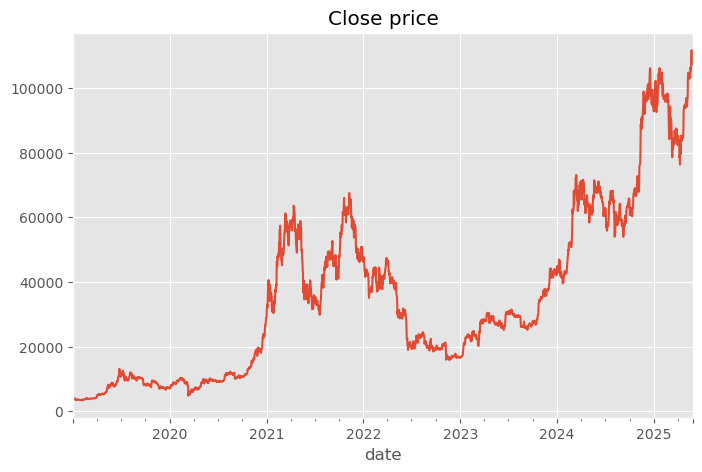

In [21]:
# Plot close price evolution
# The distribution is kinda messy, so we're using the last part for drifting avoidance 
df['close'].plot(figsize=(8,5), title='Close price', grid=True)
plt.show()

<Axes: >

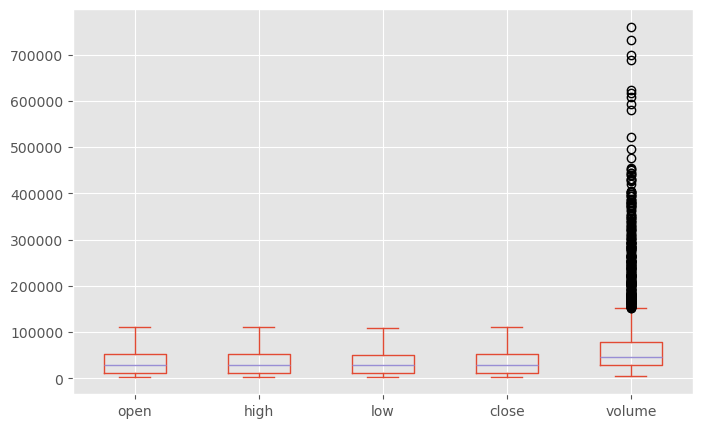

In [22]:
# Volume has a lot of outliers, we will treat it later
df[['open', 'high', 'low', 'close', 'volume']].plot(kind='box', figsize=(8,5))

In [23]:
# To avoid temporal drift or leaks, we restrict the dataset to 2024 and later
df = df[df.index >= "2024-01-01"]
df.shape

(513, 5)

In [24]:
# Split the dataset into two halves for comparison distributional changes over time
midpoint = len(df) // 2
df_2024_1 = df.iloc[:midpoint]
df_2024_2 = df.iloc[midpoint:]

In [25]:
df_2024_1.describe()

,open,high,low,close,volume
count,256.000000,256.000000,256.000000,256.000000,256.000000
mean,59849.703320,61114.898906,58518.993672,59911.614570,36778.512698
std,8929.649848,9062.014181,8689.858135,8862.070377,21877.876456
min,39568.020000,40176.740000,38555.000000,39568.020000,7308.955420
25%,55980.952500,57920.295000,54402.637500,56140.502500,22823.466480
50%,62349.985000,63572.740000,60686.285000,62349.990000,31147.805355
75%,66793.340000,68010.000000,65173.167500,66793.347500,46139.148995
max,73072.400000,73777.000000,71333.310000,73072.410000,162065.591860


In [26]:
df_2024_2.describe()

,open,high,low,close,volume
count,257.000000,257.000000,257.000000,257.000000,257.000000
mean,87728.748988,89464.658872,86060.145525,87926.433813,28800.936073
std,14027.292285,14224.717489,13708.763743,13966.424105,18088.562732
min,58132.310000,59210.700000,57493.300000,58213.990000,5420.221140
25%,80370.010000,83617.400000,77459.910000,80734.370000,16938.604520
50%,93010.010000,95000.000000,91203.670000,93442.990000,24995.702430
75%,97672.400000,99149.000000,96046.180000,97700.590000,34479.711250
max,111696.220000,111980.000000,109177.370000,111696.210000,109921.729662


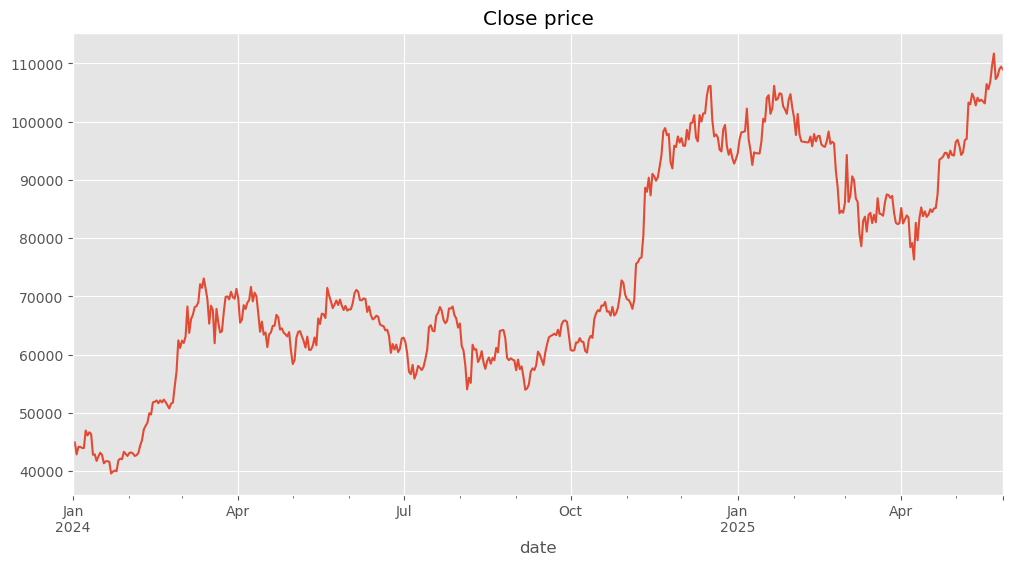

In [27]:
# Final check of close price
df['close'].plot(figsize=(12,6), title='Close price', grid=True)
plt.savefig("../reports/figures/close_price_evolution.png")
plt.show()
plt.close()

In [28]:
df['sma_10'] = ta.trend.sma_indicator(df['close'], window=10)
df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close']).average_true_range()
df = df.dropna()

<Axes: >

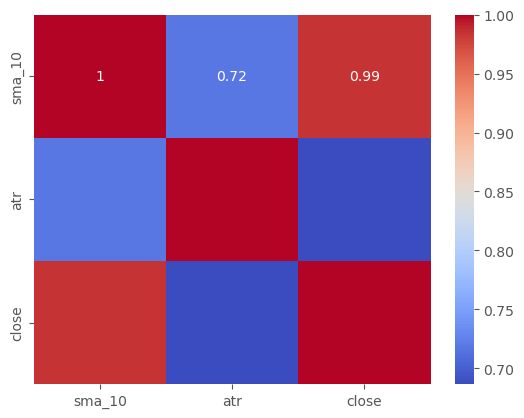

In [29]:
# Correlation between basic technical indicators and close price
matrix = df[['sma_10', 'atr', 'close']].corr()
sns.heatmap(matrix, annot=True, cmap='coolwarm')

In [30]:
# Save df for feature engineering
df.drop(columns=['sma_10', 'atr'], inplace=True)
df.to_csv('../data/df.csv', index=True)